A variety of mechanical and electrical systems can be modeled as so called linear harmonic oscillator. Its state at an time instant is described by a differential equation, that relates its internal state variable and its time derivatives with an external excitation.

For example, mechanical damped linear harmonic oscillator motion is governed by the equation

$$
m \frac{\mathrm{d}^2 x}{\mathrm{d}t^2} + c\frac{\mathrm{d} x}{\mathrm{d}t} + kx = F(t), 
$$

where $x(t)$ is displacement of the oscalliator from its equilibrium position, $m$ is its mass, $c$ is its damping coefficient, $k$ is a spring constant, and $F(t)$ is the force acting on the oscillator.

Suppose that we have obtained a time series of measurements of the displacement $x(t)$ of the oscillator when a known force $F(t)$ acts on it. We would like to estimate the parameters $m$, $c$, and $k$. Such estimates could then later be used to predict the displacement of the oscillator given any force $F(t)$ acting on it, as long as the linearity assumption holds. Such parameter estimation is sometimes called an inverse problem, whereas the displacement computation given the parameters is called a forward problem.


## Forward problem
We begin by solving the forward problem analytically, i.e. by computing the displacement $x(t)$ given the parameters $m$, $c$, and $k$, and the force $F(t)$. We will need the forward problem solution to create a model whose parameters to estimate, and to generate test measurement data $x(t) + v$ for the inverse problem. Here, $v$ will be zero mean, Gaussian distributed noise, often denoted $v \sim \mathcal{N}(0, \sigma)$, where $\sigma$ is its variance.

For easy analytic solution, suppose that the force $F(t)$ is the step function $u(t)$, and initally $x(0) = 0$ and $\mathrm{d} x / \mathrm{d}t(0) = 0$ hold. This is also often easy to realize in practice, for example, by placing an additional weight on a spring-mass system or by driving an LCR-circuit with a step voltage.

With such driving force and these initial conditions, the Laplace transformed equation is

$$
ms^2X(s) + csX(s) + msX(s) = \frac{1}{s},
$$

where $X(s)$ is the Laplace transform of $x(t)$. We solve this equation for X(s) and then find the inverse Laplace transform to find the solution for $x(t)$. To find the inverse Lapalace transform, we first factor the polynomial $ms^2 + cs + k$ by its roots, and find the partial fraction decomposition.

$$
X(s) = \frac{1}{s(ms^2 + cs + m)} = \frac{1}{s(s_1 - s)(s_2 - s)} = \frac{1}{s s_1 s_2} - \frac{1}{s_2(s−s_2)(s_1−s_2)} + \frac{1}{s_1(s−s_1)(s_1−s_2)} ,
$$

where $s_1$ and $s_2$ are the roots of the polynomial equation $ms^2 + cs + k = 0$. The inverse Laplace transform of the final form can be composed using the Laplace transform tables:

$$
x(t) = \frac{1}{s_1 s_2} - \frac{\exp(s_2t)}{s_2(s_1−s_2)} + \frac{\exp(s_1t)}{s_1(s_1−s_2)}  =
\frac{1}{k} - \frac{2m}{D(c-D)}\exp\Big(-t\frac{c-D}{2m}\Big) + \frac{2m}{D(c+D)}\exp\Big(-t\frac{c+D}{2m}\Big), 
$$

where $D = \sqrt{4c^2 - 2km}$ and $t > 0$ hold.

## Inverse problem
Suppose we have a time series of measurements $\hat{x}(t_i)$ where a step force $F(t)$ is acts on the harmonic oscillator. The aim of the inverse problem is to find the coefficients $m$, $c$, and $k$, denoted by $\theta = (m,c,k)$ in the following. From the solution of the forward problem, we can compute the corresponding values given the parameters: $x(t_i, \theta)$. Assuming the measurement data contains Gaussian distributed noise, the maximum likelihood solution $\hat{\theta}$ for the parameters is found when the sum of square differences is minimized between the measurements and the values predicted by the analytical solution:

$$
\hat{\theta} = \underset{\theta}{\operatorname{argmin}}  \sum_i \big(x(t_i, \theta) - \hat{x}(t_i) \big)^2
$$

Such problem can be solved for example by the Levenberg-Marquard algorithm for non-linear least squares problems.

We also consider a adding some outliers to the measurement data, for which assumption of Gaussian noise distribution does not hold and see if a robust estimation method can account for that.

## Python implementation

The implementation below has four steps

1. The partial fraction decomposition for the analytical solution is found using sympy
2. Noisy measurement data is generated from the an analytical solution with some parameters
3. Numerical solution of the forward problem is computed to check the analytical solution correctness
4. The parameters are estimated from the noisy measurement data using the Levenber-Marquard algorithm and with a robust algorithm
5. The estimated parameters are used to predict the displacement of the oscillator under a specified force

In [338]:
# preample
import numpy as np
import matplotlib.pyplot as plt; 
from IPython.display import display
%matplotlib inline
from IPython.display import set_matplotlib_formats; set_matplotlib_formats('pdf', 'png')

In [339]:
# partial fraction decomposition using sympy

from sympy import init_printing
init_printing(use_latex='mathjax')
from sympy import Symbol, apart


s = Symbol('s')
s1 = Symbol('s1')
s2 = Symbol('s2')


X = apart(1/s/(s1-s)/(s2-s),s, full=True).doit()
display(X)



            1                       1                1   
- ───────────────────── + ───────────────────── + ───────
  s₂⋅(s - s₂)⋅(s₁ - s₂)   s₁⋅(s - s₁)⋅(s₁ - s₂)   s⋅s₁⋅s₂

In [340]:
## generate simulated measurement data by adding random noise to the analytical solution

# analytical solution function
def x_model(theta, t):
    m = theta[0]; c = theta[1]; k = theta[2]
    D = np.sqrt(c*c-4*k*m + 0j)
    x = 1/k - 2*m/(D*(c-D))*np.exp(-t*(c-D)/(2*m)) + 2*m/(D*(c+D))*np.exp(-t*(c+D)/(2*m))
    return np.real(x)

# random parameters
theta = 10*np.random.rand(3)

# fixed parameters
theta[0] = 6
theta[1] = 2
theta[2] = 4

print("Parameters: m = %g, c = %g, k = %g" % (theta[0],theta[1],theta[2]) ) 

# time
t = np.linspace(0, 50, 1000)

# analytic solution
x_a = x_model(theta, t)

# analytic solution with added zero mean Gaussian noise
sigma = 0.01
x_n = x_a + sigma*np.max(x_a)*(np.random.randn(x_a.shape[0])-0.5)

# add some outliers
outlier_proportion = 0.1
outlier_magnitude = 20
ind = np.random.randint(0, x_a.shape[0], round(x_a.shape[0]*outlier_proportion))
x_n[ind] = x_n[ind] + outlier_magnitude*np.mean(x_a)*(np.random.rand(ind.shape[0])-0.5) 

Parameters: m = 6, c = 2, k = 4


In [341]:
## numerical solution
from scipy.integrate import odeint

# drive with unit step
def Fstep(t):
    F = 0
    if t > 0: F = 1
    return F

# right hand side of the differential equation system y' = f(y,t)
def f(x, t, theta, F):
    m = theta[0]; c = theta[1]; k = theta[2]
    M = np.array([[m, c],[0,1]])
    b = np.array([F(t) - k*x[1], x[0]])
    return np.linalg.solve(M,b)

# initial value
x0 = np.array([0, 0])
# solve
x_o = odeint(f, x0, t,  args=(theta, Fstep) )

In [342]:
## estimate parameters

from scipy.optimize import root
from scipy.optimize import least_squares

# square terms of the sum to be minimized
def ssd(theta, x_m, t_m):
    d = x_m-x_model(theta,t)
    return d

# initial guess
theta0 = np.array([1, 1, 1])

# minimize the sum of squares (find roots of a vector-valued multivariate function)
out = root(ssd, theta0, args=(x_n, t), method='lm', jac=None, tol=None, callback=None, options=None) 
theta_est = out.x
print(theta_est)

# find a robust estimate with Cauchy loss function
out = least_squares(ssd, theta0, jac='2-point', bounds=(-np.inf, np.inf), 
              method='trf', ftol=1e-08, xtol=1e-08, gtol=1e-08, x_scale=1.0, 
              loss='cauchy', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, 
              jac_sparsity=None, max_nfev=None, verbose=0, 
              args=(x_n, t), kwargs={})
theta_est_robust = out.x

# estimated solution
x_est = x_model(theta_est, t)
x_est_robust = x_model(theta_est_robust, t)

[ 1.83083966  2.40184202  4.1467253 ]


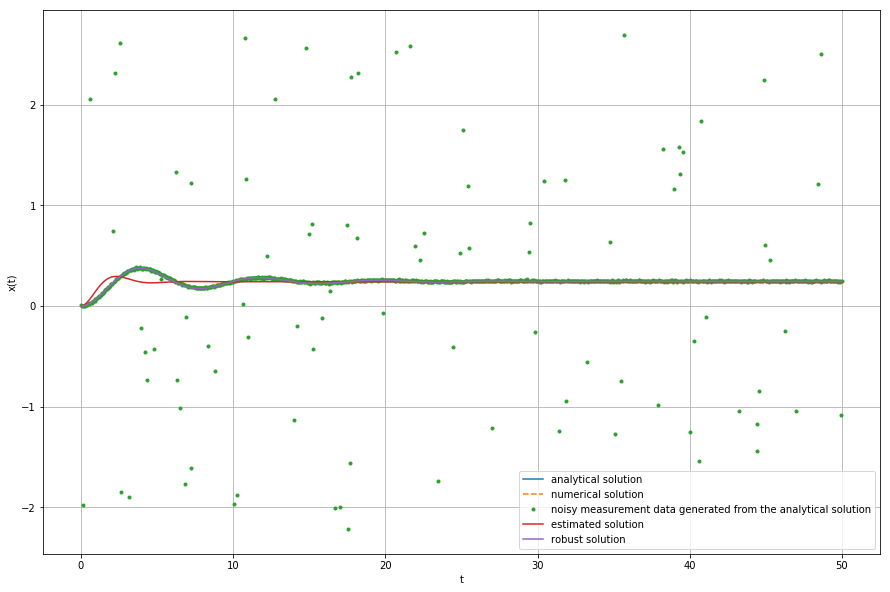

In [343]:
## plot 
plt.figure(figsize=(15,10))
plt.plot(t,x_a);
plt.plot(t,x_o[:,1], '--'); 
plt.plot(t,x_n, '.');
plt.plot(t,x_est,);
plt.plot(t,x_est_robust,);
plt.grid(); plt.xlabel('t');  plt.ylabel('x(t)'); 
plt.legend(['analytical solution', 'numerical solution', 
            'noisy measurement data generated from the analytical solution',
            'estimated solution', 'robust solution']);

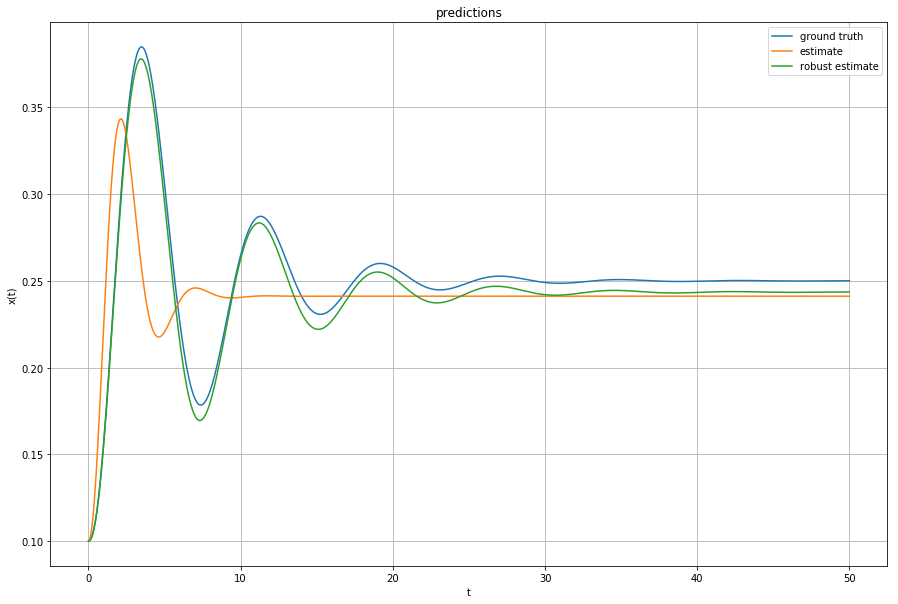

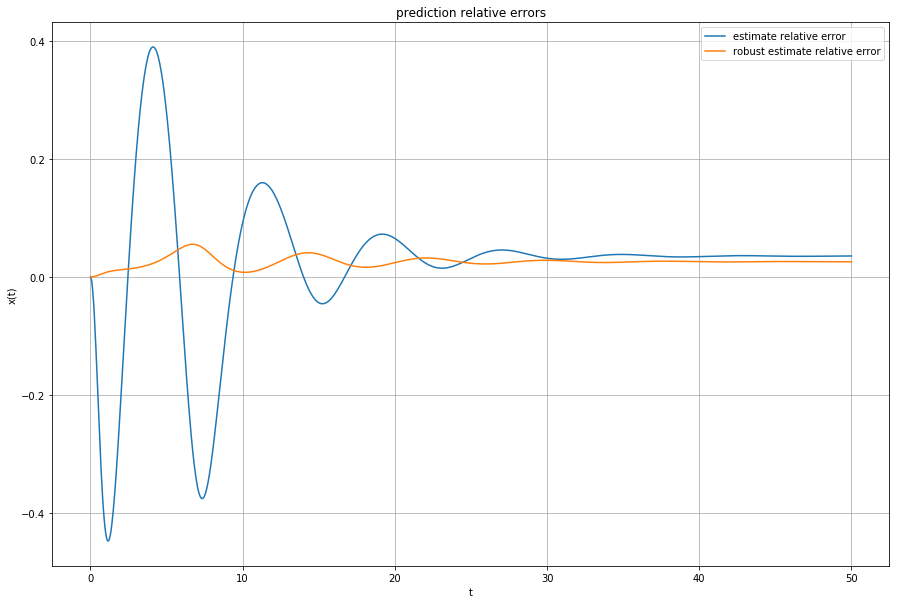

In [344]:
## predict numerically

# drive by exponentially decaying sinusoid
def Fdecay(t):
    return 1+np.sin(t)*np.exp(-t)

# initial value
x0 = np.array([0, 0.1])
# solve
x_er = odeint(f, x0, t,  args=(theta_est_robust, Fdecay) )
x_e = odeint(f, x0, t,  args=(theta_est, Fdecay) )
x_g = odeint(f, x0, t,  args=(theta, Fdecay) )

plt.figure(figsize=(15,10))
plt.plot(t,x_g[:,1]);
plt.plot(t,x_e[:,1]);
plt.plot(t,x_er[:,1]);
plt.grid(); plt.xlabel('t');  plt.ylabel('x(t)');
plt.title('predictions')
plt.legend(['ground truth','estimate', 'robust estimate']);

plt.figure(figsize=(15,10))
plt.plot(t,(x_g[:,1]-x_e[:,1])/(x_g[:,1])) ;
plt.plot(t,(x_g[:,1]-x_er[:,1])/(x_g[:,1]) ) ;
plt.grid(); plt.xlabel('t');  plt.ylabel('x(t)');
plt.title('prediction relative errors')
plt.legend(['estimate relative error', 'robust estimate relative error']);

## Conclusion
We were able to derive analytical solution to the differential equation describing the displacement of a harmonic oscillator under the influence of a step force. The solution depends on the parameters of the oscillator, and by measuring the displacement we were able to solve the parameters by least squares fitting. When the measurement contained outliers, a robust estimation method was able to decrease their influence on the solution. Using the estimated parameters, as long as the linearity assumption holds, one can predict the displacement of the oscillator under any force, not just the step force that was used estimate the paramers.